In [26]:
import sys
sys.path.append("/home/libo/project/cm/trunck-consistency-policy")

from diffusion_policy.common.replay_buffer import ReplayBuffer
import zarr

root = zarr.open("/data/robot_dataset/metaworld/mt50_v3_zarr/assembly-v3.zarr", mode="r")
rb = ReplayBuffer.create_from_group(root)
print(rb.n_episodes)                 # 例如: 100
ep0 = rb.get_episode(0)              # dict-like: 各键按时间切片后的 numpy
print(ep0.keys())                    # e.g. dict_keys(['action','state','qpos','robot0_arm_qpos','camera0_rgb',...])


2
dict_keys(['action', 'gripperPOV', 'proprio', 'qpos', 'state', 'topview'])


In [27]:
import os
from typing import Optional, Tuple, Dict

import numpy as np
import zarr
import imageio.v2 as iio  # imageio 的 v2 API：mimsave/duration 更稳定


In [23]:

def show_dataset_shapes(zarr_path: str) -> Dict[str, Tuple]:
    """打印 /data 下各数组的形状与 dtype，并核对是否与 episode_ends 对齐。
    返回一个 {key: shape} 的 dict，方便上层调用使用。
    """
    root = zarr.open(zarr_path, mode="r")
    data = root["data"]
    ep_ends = np.asarray(root["meta"]["episode_ends"])
    assert ep_ends.ndim == 1 and ep_ends.size > 0, "episode_ends 为空或维度不正确"
    N = int(ep_ends[-1])

    print(f"[INFO] file: {zarr_path}")
    print(f"[INFO] total steps (episode_ends[-1]): {N}")
    print(f"[INFO] #episodes: {len(ep_ends)} (exclusive end indices)")

    shapes = {}
    for k, arr in data.items():
        shp, dt = arr.shape, arr.dtype
        ok = (shp[0] == N)
        tag = "OK " if ok else "BAD"
        print(f"  - {k:20s} shape={shp!r:18s} dtype={str(dt):8s} --> {tag}")
        shapes[k] = shp

    # 额外提示：列出每个 episode 的 [start, end)
    starts = np.concatenate([[0], ep_ends[:-1]])
    print("[INFO] episodes (start, end):")
    # 只预览前几个，避免刷屏
    for i, (s, e) in enumerate(zip(starts[:10], ep_ends[:10])):
        print(f"    ep{i:03d}: [{int(s)}, {int(e)})  len={int(e - s)}")
    if len(ep_ends) > 10:
        print("    ...")

    return shapes


In [24]:

def save_episode_gif(
    zarr_path: str,
    camera_key: str = "camera0_rgb",
    ep_index: int = 0,
    out_path: Optional[str] = None,
    fps: int = 10,
    stride: int = 1,
    resize_hw: Optional[Tuple[int, int]] = None,
):
    """把某个 episode 的相机帧导出为 GIF。
    Args:
        zarr_path: 形如 ".../assembly-v3.zarr"
        camera_key: /data 下相机数组名，如 "camera0_rgb"
        ep_index: 导出第几个 episode（0-based）
        out_path: 输出 GIF 路径；默认保存在同目录下 "episode_{idx}_{camera}.gif"
        fps: GIF 帧率（内部会转成每帧时长）
        stride: 抽帧步长（=2 表示隔帧取，文件更小）
        resize_hw: 可选 (H, W)，导出前重采样，进一步减小 GIF 大小
    """
    root = zarr.open(zarr_path, mode="r")
    data = root["data"]
    assert camera_key in data, f"'{camera_key}' not found in /data keys: {list(data.array_keys())}"
    cam = data[camera_key]

    ep_ends = np.asarray(root["meta"]["episode_ends"])
    assert ep_ends.ndim == 1 and ep_ends.size > 0
    starts = np.concatenate([[0], ep_ends[:-1]])
    assert 0 <= ep_index < len(ep_ends), f"ep_index out of range (0..{len(ep_ends)-1})"
    s, e = int(starts[ep_index]), int(ep_ends[ep_index])
    assert e > s, "Empty episode?"

    # 读出该 episode 的帧并可选抽帧
    # ...existing code...
    frames = cam[s:e:stride]  # (T, C, H, W) or (T, H, W, C)
    if frames.ndim == 4 and frames.shape[1] in [1, 3, 4]:
        # Convert from (T, C, H, W) to (T, H, W, C)
        frames = np.transpose(frames, (0, 2, 3, 1))
    # ...existing code...
    # 可选重采样（注意：GIF 尺寸越小越省）
    if resize_hw is not None:
        import cv2
        H, W = resize_hw
        frames = np.stack([cv2.resize(fr, (W, H), interpolation=cv2.INTER_AREA) for fr in frames], axis=0)

    # imageio.mimsave 支持直接喂 (T,H,W,C) 的 uint8 数组
    # duration 单位是“每帧毫秒”或“秒”，取决于版本；用 v2 的 duration=秒 更统一
    duration = 1.0 / max(fps, 1)
    if out_path is None:
        env_name = os.path.splitext(os.path.basename(zarr_path))[0]
        out_path = os.path.join(os.path.dirname(zarr_path),
                                f"{env_name}_ep{ep_index:03d}_{camera_key}.gif")

    iio.mimsave(out_path, frames, duration=duration, loop=0)  # loop=0 表示无限循环
    print(f"[OK] GIF saved: {out_path}  (frames={frames.shape[0]}, fps={fps}, stride={stride})")

In [25]:
z = "/data/robot_dataset/metaworld/mt50_v3_zarr/assembly-v3.zarr"
ep_index = 0
fps = 12
stride = 2
resize_hw = (224, 224)

for camera_key in ["corner", "corner2", "corner3", "corner4", "gripperPOV", "topview", "behindGripper"]:
    out_file = f"/home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep{ep_index:03d}_{camera_key}.gif"
    save_episode_gif(
        z,
        camera_key=camera_key,
        ep_index=ep_index,
        fps=fps,
        stride=stride,
        resize_hw=resize_hw,
        out_path=out_file
    )

[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_corner.gif  (frames=45, fps=12, stride=2)
[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_corner2.gif  (frames=45, fps=12, stride=2)
[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_corner3.gif  (frames=45, fps=12, stride=2)
[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_corner4.gif  (frames=45, fps=12, stride=2)
[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_gripperPOV.gif  (frames=45, fps=12, stride=2)
[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_topview.gif  (frames=45, fps=12, stride=2)
[OK] GIF saved: /home/libo/project/cm/trunck-consistency-policy/create_data/assembly-v3_ep000_behindGripper.gif  (frames=45, fps=12, stride=2)


In [17]:
z ="/data/robot_dataset/metaworld/mt50_v3_zarr/assembly-v3.zarr"

# 1) 打印维度与一致性
show_dataset_shapes(z)

# 2) 导出第 0 个 episode 的 corner 相机为 GIF，FPS=12，隔帧取一半，并把分辨率缩小到 256x256
save_episode_gif(z, camera_key="corner", ep_index=0, fps=12, stride=2, resize_hw=(256, 256))


[INFO] file: /data/robot_dataset/metaworld/mt50_v3_zarr/assembly-v3.zarr
[INFO] total steps (episode_ends[-1]): 184
[INFO] #episodes: 2 (exclusive end indices)
  - action               shape=(184, 4)           dtype=float32  --> OK 
  - behindGripper        shape=(184, 3, 256, 256) dtype=uint8    --> OK 
  - corner               shape=(184, 3, 256, 256) dtype=uint8    --> OK 
  - corner2              shape=(184, 3, 256, 256) dtype=uint8    --> OK 
  - corner3              shape=(184, 3, 256, 256) dtype=uint8    --> OK 
  - corner4              shape=(184, 3, 256, 256) dtype=uint8    --> OK 
  - gripperPOV           shape=(184, 3, 256, 256) dtype=uint8    --> OK 
  - proprio              shape=(184, 7)           dtype=float32  --> OK 
  - qpos                 shape=(184, 16)          dtype=float32  --> OK 
  - robot0_arm_qpos      shape=(184, 7)           dtype=float32  --> OK 
  - state                shape=(184, 39)          dtype=float32  --> OK 
  - topview              shape=(184, 

KeyError: 256

# RLBENCH

In [ ]:
import os
from glob import glob
from typing import Dict, List, Optional, Tuple

import cv2
import imageio.v2 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zarr


In [ ]:

# ========================
# 核心工具
# ========================
def find_zarr_roots(base_dir: str) -> List[str]:
    paths = sorted(glob(os.path.join(base_dir, "*.zarr")))
    return [p for p in paths if os.path.isdir(p)]


def read_episode_ends(root: zarr.hierarchy.Group) -> np.ndarray:
    ep = np.asarray(root["meta"]["episode_ends"])
    assert ep.ndim == 1 and ep.size > 0, "episode_ends 为空或维度不正确"
    return ep


def list_data_shapes(root: zarr.hierarchy.Group) -> Dict[str, Tuple[int, ...]]:
    d = root["data"]
    return {k: tuple(v.shape) for k, v in d.items()}


def infer_active_cameras(root: zarr.hierarchy.Group) -> List[str]:
    keys = list(root["data"].array_keys())
    cams = sorted([k for k in keys if k.startswith("camera") and k.endswith("_rgb")])
    return cams


def summarize_one_zarr(zarr_path: str) -> Dict:
    root = zarr.open(zarr_path, mode="r")
    ep = read_episode_ends(root)
    N = int(ep[-1])
    starts = np.concatenate([[0], ep[:-1]])
    ep_lens = (ep - starts).astype(int)

    data_shapes = list_data_shapes(root)
    cams = infer_active_cameras(root)

    # 相机分辨率（取第一个相机做代表）
    cam_reso = None
    if cams:
        shp = data_shapes[cams[0]]
        cam_reso = (int(shp[1]), int(shp[2])) if len(shp) == 4 else None

    return {
        "zarr_path": zarr_path,
        "task": os.path.splitext(os.path.basename(zarr_path))[0],
        "num_episodes": len(ep),
        "total_steps": N,
        "ep_len_mean": float(ep_lens.mean()),
        "ep_len_median": int(np.median(ep_lens)),
        "ep_len_min": int(ep_lens.min()),
        "ep_len_max": int(ep_lens.max()),
        "cameras": ",".join(cams),
        "resolution": f"{cam_reso[0]}x{cam_reso[1]}" if cam_reso else "",
        "data_shapes": data_shapes,
        "episode_ends": ep,
        "episode_lengths": ep_lens,
    }


def ensure_outdir(path: str) -> str:
    os.makedirs(path, exist_ok=True)
    return path


def save_bar(values: Dict[str, int], title: str, out_png: str, rotation: int = 45):
    plt.figure()
    names = list(values.keys())
    nums = [int(values[k]) for k in names]
    plt.bar(range(len(names)), nums)
    plt.xticks(range(len(names)), names, rotation=rotation, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()


def save_hist(data: np.ndarray, title: str, out_png: str, bins: int = 30):
    plt.figure()
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel("Episode length (steps)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()


def save_boxplot(groups: Dict[str, np.ndarray], title: str, out_png: str):
    # 仅取前 N（避免任务太多导致坐标轴拥挤）
    items = list(groups.items())
    labels = [k for k, _ in items]
    data = [v for _, v in items]
    plt.figure()
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()


def save_episode_gif(root: zarr.hierarchy.Group,
                     camera_key: str,
                     ep_idx: int,
                     out_gif: str,
                     fps: int = 12,
                     stride: int = 4,
                     resize_hw: Optional[Tuple[int, int]] = (256, 256)):
    ep = read_episode_ends(root)
    starts = np.concatenate([[0], ep[:-1]])
    s, e = int(starts[ep_idx]), int(ep[ep_idx])
    frames = root["data"][camera_key][s:e:stride]  # (T,H,W,3) uint8

    if resize_hw is not None:
        H, W = resize_hw
        frames = np.stack([cv2.resize(fr, (W, H), interpolation=cv2.INTER_AREA) for fr in frames], axis=0)

    duration = 1.0 / max(fps, 1)
    iio.mimsave(out_gif, frames, duration=duration, loop=0)


In [ ]:
# -*- coding: utf-8 -*-
from typing import Dict, List, Optional, Tuple
import os
import io

import cv2
import zarr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image as IPyImage
from PIL import Image as PILImage

# -------- 仍沿用你已有的工具：find_zarr_roots / summarize_one_zarr 等 --------
# 假设以下函数已在你的文件中定义：
# - find_zarr_roots(base_dir) -> List[str]
# - summarize_one_zarr(zarr_path) -> Dict
# - read_episode_ends(root) -> np.ndarray

def _bar_inline(values: Dict[str, int], title: str, rotation: int = 45):
    fig, ax = plt.subplots(figsize=(max(6, len(values) * 0.5), 4))
    names = list(values.keys())
    nums = [int(values[k]) for k in names]
    ax.bar(range(len(names)), nums)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=rotation, ha="right")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def _hist_inline(data: np.ndarray, title: str, bins: int = 30):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(data, bins=bins)
    ax.set_title(title)
    ax.set_xlabel("Episode length (steps)")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def _boxplot_inline(groups: Dict[str, np.ndarray], title: str):
    items = list(groups.items())
    labels = [k for k, _ in items]
    data = [v for _, v in items]
    fig, ax = plt.subplots(figsize=(max(6, len(labels) * 0.6), 4))
    ax.boxplot(data, showmeans=True)
    ax.set_title(title)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def _display_episode_gif_inline(root: zarr.hierarchy.Group,
                                camera_key: str,
                                ep_idx: int,
                                fps: int = 12,
                                stride: int = 4,
                                resize_hw: Optional[Tuple[int, int]] = (256, 256)):
    """在 Jupyter 中直接显示某个 episode 的 GIF（不写文件）"""
    ep = np.asarray(root["meta"]["episode_ends"])
    starts = np.concatenate([[0], ep[:-1]])
    s, e = int(starts[ep_idx]), int(ep[ep_idx])
    frames = root["data"][camera_key][s:e:stride]  # (T,H,W,3) uint8

    if resize_hw is not None:
        H, W = resize_hw
        frames = np.stack([cv2.resize(fr, (W, H), interpolation=cv2.INTER_AREA) for fr in frames], axis=0)

    pil_frames = [PILImage.fromarray(fr) for fr in frames]
    dur_ms = int(1000 / max(1, fps))

    buf = io.BytesIO()
    # Pillow 动图：首帧 save_all + append_images + duration + loop
    pil_frames[0].save(buf, format="GIF", save_all=True,
                       append_images=pil_frames[1:], duration=dur_ms, loop=0)
    buf.seek(0)
    display(IPyImage(data=buf.getvalue()))

def visualize_rlbench_inline(base_dir: str,
                             max_gifs: int = 6,
                             gif_stride: int = 4,
                             gif_fps: int = 12,
                             gif_resize: Tuple[int, int] = (256, 256),
                             topN_boxplot: int = 12):
    """Jupyter 直接展示统计与 GIF，不保存任何文件。"""
    zarr_paths = [p for p in sorted(os.listdir(base_dir))
                  if p.endswith(".zarr") and os.path.isdir(os.path.join(base_dir, p))]
    zarr_paths = [os.path.join(base_dir, p) for p in zarr_paths]
    assert zarr_paths, f"未在 {base_dir} 发现 *.zarr 目录"

    # 逐任务汇总
    summaries = [summarize_one_zarr(p) for p in zarr_paths]

    # 1) 汇总表直接展示
    df_rows = []
    for s in summaries:
        df_rows.append({
            "task": s["task"],
            "num_episodes": s["num_episodes"],
            "total_steps": s["total_steps"],
            "ep_len_mean": round(s["ep_len_mean"], 2),
            "ep_len_median": s["ep_len_median"],
            "ep_len_min": s["ep_len_min"],
            "ep_len_max": s["ep_len_max"],
            "cameras": s["cameras"],
            "resolution": s["resolution"],
        })
    df = pd.DataFrame(df_rows).sort_values(by="total_steps", ascending=False)
    display(Markdown("### Dataset Summary"))
    display(df)

    # 2) 每个 task 的 /data 键与 shape（预览）
    display(Markdown("### Per-task data keys & shapes (preview)"))
    for s in summaries[:10]:  # 只展示前 10 个，避免刷屏
        kv = "\n".join([f"- `{k}`: {tuple(v)}" for k, v in s["data_shapes"].items()])
        display(Markdown(f"**{s['task']}**  \n{kv}"))

    # 3) 可视化：柱状图/直方图/箱线图（全部 plt.show）
    episodes_map = {s["task"]: int(s["num_episodes"]) for s in summaries}
    steps_map = {s["task"]: int(s["total_steps"]) for s in summaries}
    _bar_inline(episodes_map, "Episodes per task")
    _bar_inline(steps_map, "Total steps per task")

    all_ep_lens = np.concatenate([s["episode_lengths"] for s in summaries], axis=0)
    _hist_inline(all_ep_lens, "Episode length distribution (all tasks)", bins=30)

    top_tasks = [t for t, _ in sorted(steps_map.items(), key=lambda x: -x[1])[:topN_boxplot]]
    box_groups = {s["task"]: s["episode_lengths"] for s in summaries if s["task"] in top_tasks}
    _boxplot_inline(box_groups, "Episode length per task (boxplot, top-N)")

    # 4) 预览 GIF：最多 N 个任务，各展示第 0 个 episode（若有相机）
    display(Markdown("### GIF previews"))
    exported = 0
    for s in summaries:
        if exported >= max_gifs:
            break
        cams = s["cameras"].split(",") if s["cameras"] else []
        if not cams:
            continue
        root = zarr.open(s["zarr_path"], mode="r")
        display(Markdown(f"**{s['task']}** — `{cams[0]}` / episode 0"))
        try:
            _display_episode_gif_inline(root, cams[0], 0,
                                        fps=gif_fps, stride=gif_stride, resize_hw=gif_resize)
            exported += 1
        except Exception as e:
            display(Markdown(f"> GIF 预览失败：`{s['task']}` — {e}"))


### Dataset Summary

,task,num_episodes,total_steps,ep_len_mean,ep_len_median,ep_len_min,ep_len_max,cameras,resolution
9,put_shoes_in_box,200,85816,429.08,417,379,540,,
6,put_item_in_drawer,200,61457,307.29,306,278,361,,
13,take_item_out_of_drawer,200,59996,299.98,296,272,430,,
10,put_umbrella_in_umbrella_stand,200,35790,178.95,170,125,391,,
15,take_plate_off_colored_dish_rack,200,34802,174.01,183,124,293,,
2,open_grill,200,33015,165.07,179,102,262,,
7,put_knife_on_chopping_board,200,32797,163.99,164,107,323,,
8,put_rubbish_in_bin,200,31259,156.29,140,101,317,,
0,open_box,200,30487,152.44,149,135,190,,
4,phone_on_base,200,30217,151.09,131,88,338,,


### Per-task data keys & shapes (preview)

**open_box**  
- `action`: (30487, 7)
- `agent_pos`: (30487, 6)
- `front_camera_extrinsics`: (30487, 4, 4)
- `img`: (30487, 120, 120, 3)
- `obj_pcd`: (30487, 512, 3)
- `obj_split`: (30487, 1, 512, 3)
- `pcd`: (30487, 1024, 3)
- `wrist_camera_extrinsics`: (30487, 4, 4)
- `wrist_point_cloud`: (30487, 120, 120, 3)
- `wrist_rgb`: (30487, 120, 120, 3)

**open_drawer**  
- `action`: (20834, 7)
- `agent_pos`: (20834, 6)
- `front_camera_extrinsics`: (20834, 4, 4)
- `img`: (20834, 120, 120, 3)
- `obj_pcd`: (20834, 512, 3)
- `obj_split`: (20834, 1, 512, 3)
- `pcd`: (20834, 1024, 3)
- `wrist_camera_extrinsics`: (20834, 4, 4)
- `wrist_point_cloud`: (20834, 120, 120, 3)
- `wrist_rgb`: (20834, 120, 120, 3)

**open_grill**  
- `action`: (33015, 7)
- `agent_pos`: (33015, 6)
- `front_camera_extrinsics`: (33015, 4, 4)
- `img`: (33015, 120, 120, 3)
- `obj_pcd`: (33015, 512, 3)
- `obj_split`: (33015, 1, 512, 3)
- `pcd`: (33015, 1024, 3)
- `wrist_camera_extrinsics`: (33015, 4, 4)
- `wrist_point_cloud`: (33015, 120, 120, 3)
- `wrist_rgb`: (33015, 120, 120, 3)

**open_wine_bottle**  
- `action`: (27710, 7)
- `agent_pos`: (27710, 6)
- `front_camera_extrinsics`: (27710, 4, 4)
- `img`: (27710, 120, 120, 3)
- `obj_pcd`: (27710, 512, 3)
- `obj_split`: (27710, 1, 512, 3)
- `pcd`: (27710, 1024, 3)
- `wrist_camera_extrinsics`: (27710, 4, 4)
- `wrist_point_cloud`: (27710, 120, 120, 3)
- `wrist_rgb`: (27710, 120, 120, 3)

**phone_on_base**  
- `action`: (30217, 7)
- `agent_pos`: (30217, 6)
- `front_camera_extrinsics`: (30217, 4, 4)
- `img`: (30217, 120, 120, 3)
- `obj_pcd`: (30217, 512, 3)
- `obj_split`: (30217, 2, 512, 3)
- `pcd`: (30217, 1024, 3)
- `wrist_camera_extrinsics`: (30217, 4, 4)
- `wrist_point_cloud`: (30217, 120, 120, 3)
- `wrist_rgb`: (30217, 120, 120, 3)

**push_button**  
- `action`: (16741, 7)
- `agent_pos`: (16741, 6)
- `front_camera_extrinsics`: (16741, 4, 4)
- `img`: (16741, 120, 120, 3)
- `obj_pcd`: (16741, 512, 3)
- `obj_split`: (16741, 1, 512, 3)
- `pcd`: (16741, 1024, 3)
- `wrist_camera_extrinsics`: (16741, 4, 4)
- `wrist_point_cloud`: (16741, 120, 120, 3)
- `wrist_rgb`: (16741, 120, 120, 3)

**put_item_in_drawer**  
- `action`: (61457, 7)
- `agent_pos`: (61457, 6)
- `front_camera_extrinsics`: (61457, 4, 4)
- `img`: (61457, 120, 120, 3)
- `obj_pcd`: (61457, 512, 3)
- `obj_split`: (61457, 2, 512, 3)
- `pcd`: (61457, 1024, 3)
- `wrist_camera_extrinsics`: (61457, 4, 4)
- `wrist_point_cloud`: (61457, 120, 120, 3)
- `wrist_rgb`: (61457, 120, 120, 3)

**put_knife_on_chopping_board**  
- `action`: (32797, 7)
- `agent_pos`: (32797, 6)
- `front_camera_extrinsics`: (32797, 4, 4)
- `img`: (32797, 120, 120, 3)
- `obj_pcd`: (32797, 512, 3)
- `obj_split`: (32797, 1, 512, 3)
- `pcd`: (32797, 1024, 3)
- `wrist_camera_extrinsics`: (32797, 4, 4)
- `wrist_point_cloud`: (32797, 120, 120, 3)
- `wrist_rgb`: (32797, 120, 120, 3)

**put_rubbish_in_bin**  
- `action`: (31259, 7)
- `agent_pos`: (31259, 6)
- `front_camera_extrinsics`: (31259, 4, 4)
- `img`: (31259, 120, 120, 3)
- `obj_pcd`: (31259, 512, 3)
- `obj_split`: (31259, 2, 512, 3)
- `pcd`: (31259, 1024, 3)
- `wrist_camera_extrinsics`: (31259, 4, 4)
- `wrist_point_cloud`: (31259, 120, 120, 3)
- `wrist_rgb`: (31259, 120, 120, 3)

**put_shoes_in_box**  
- `action`: (85816, 7)
- `agent_pos`: (85816, 6)
- `front_camera_extrinsics`: (85816, 4, 4)
- `img`: (85816, 120, 120, 3)
- `obj_pcd`: (85816, 512, 3)
- `obj_split`: (85816, 3, 512, 3)
- `pcd`: (85816, 1024, 3)
- `wrist_camera_extrinsics`: (85816, 4, 4)
- `wrist_point_cloud`: (85816, 120, 120, 3)
- `wrist_rgb`: (85816, 120, 120, 3)

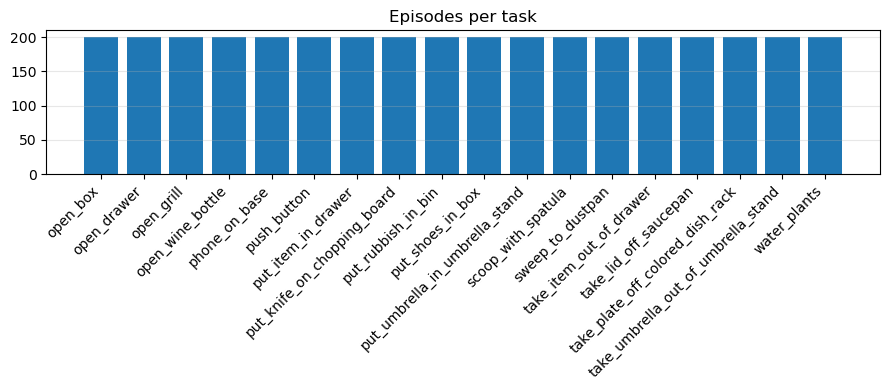

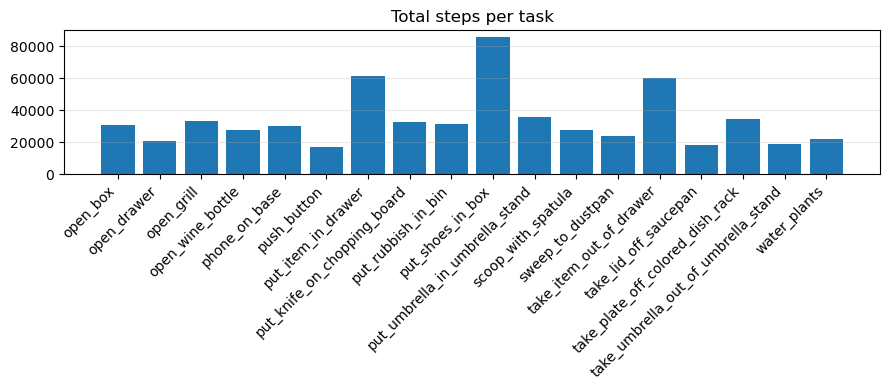

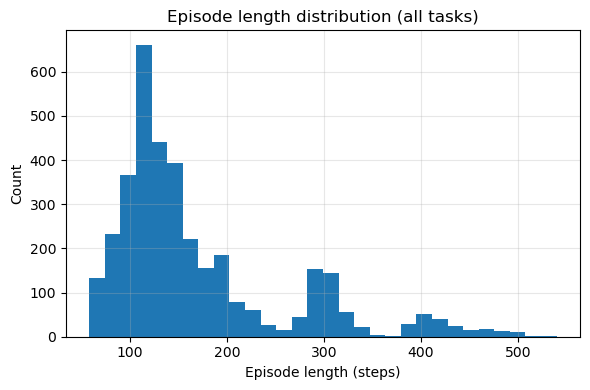

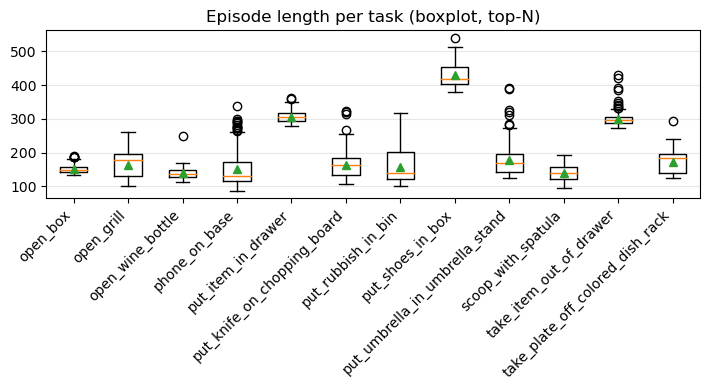

### GIF previews

In [ ]:
BASE_DIR = "/data/robot_dataset/rlbench"
visualize_rlbench_inline(BASE_DIR, max_gifs=6, gif_stride=4, gif_fps=12, gif_resize=(256,256))
